# Imports

In [1]:
import h5py
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sn
import pandas as pd

import math
import random

%matplotlib inline

# Notify when finished training
%load_ext jupyternotify


print("Test")

<IPython.core.display.Javascript object>

Test


# Is using GPU?

In [2]:
import tensorflow
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

print("CPU:")
print(tensorflow.config.experimental.list_physical_devices('CPU'))
print("GPU:")
print(tensorflow.config.experimental.list_physical_devices('GPU'))

CPU:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU:
[]


# Load constants

In [3]:
FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']
# Pre-calculated average width, height of all cropped train data
AVG_CHAR_WIDTH = 28
AVG_CHAR_HEIGHT = 49

train_filename = "font_recognition_train_set/SynthText.h5"
val_filename = "validation_set/SynthText_val.h5"

# func: Crop the word with perfect angle - affine transformation

Tutorial that helped me:

https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

In [4]:
def crop_affine(img, bb):
    """
    Crop image using affine transformation, around bounding box. Returns cropped image.
    """
    img_copy = img.copy()
    width = img_copy.shape[1]
    height = img_copy.shape[0]
        
    point1 = (bb[0][0], bb[1][0]) # Top-left
    point2 = (bb[0][1], bb[1][1]) # Top-right
    point3 = (bb[0][2], bb[1][2]) # Bottom-Right
    point4 = (bb[0][3], bb[1][3]) # Bottom-Left
    
    # Euclidian distance
    bb_width = int(np.linalg.norm(np.array(point1) - np.array(point2)))
    bb_height = int(np.linalg.norm(np.array(point1) - np.array(point3)))

    # Mapping srcPoints (list of points of size 3) to dstPoints (list of points of size 3)
    srcTri = np.array( [point1, point2, point4] ).astype(np.float32)
    dstTri = np.array( [[0, 0], [bb_width, 0], [0, bb_height]] ).astype(np.float32)
    
    # Apply transformation
    warp_mat = cv2.getAffineTransform(srcTri, dstTri)
    warp_dst = cv2.warpAffine(img_copy, warp_mat, (width, height))
    
    # Crop the 'warped' image
    crop = warp_dst[0:bb_height, 0:bb_width]
    
    return crop

# func: Normalize function

![](images/normalize_formula.png)

In [5]:
def normalize(img, low=0, high=1):
    """
    Normalize image to range [low, high] from any range. Note: fast algorithm.
    """
    return np.interp(img, [np.min(img), np.max(img)], [low, high])

# func: Extract data from image name return json

In [6]:
def extract_data(db, img_name:str):
    """
    Process the image and returned processed result.
    Parameter db is h5 database read from file.
    Return a json in the following structure (as an example):
    {
        "img": <ndarray>,
        "name": "test.png",
        "words": [
            {
                "word": "the",
                "font": "Ubuntu Mono",
                "chars": [
                    {
                        "char": "t",
                        "font": "Ubuntu Mono",
                        "crop": <ndarray>,
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
                "crop": <ndarray>
            }, ...
        ]
    }
    """
    img = db['data'][img_name][:]                 # The image.
    font = db['data'][img_name].attrs['font']     # Contains list of fonts.
    txt = db['data'][img_name].attrs['txt']       # Contains list of words.
    charBB = db['data'][img_name].attrs['charBB'] # Contains list of bb for words.
    wordBB = db['data'][img_name].attrs['wordBB'] # Contain list of bb for chars.


    words = []
    char_index_accumulator = 0
    word_index = 0 # Counter
    
    # Process word
    for word in txt:
        word_font = font[char_index_accumulator].decode() # Convert bytes to string
        chars = []

        word_bb = wordBB[:, :, word_index]
        word_crop = crop_affine(img, word_bb)

        # Process chars
        for char_index in range(len(word)):
            char = chr(word[char_index])
            char_font = font[char_index_accumulator].decode()
            char_bb = charBB[:, :, char_index_accumulator]
            
            #assert char_font == word_font # Double check that the pre-processed image is indeed 1 font per word, and each char is same font as word.
            
            crop_char = crop_affine(img, char_bb)
            
            chars.append({
                "char": char,
                "font": char_font,
                "crop": crop_char,
                "bb": char_bb
            })
            
            char_index_accumulator += 1

        words.append({
            "word": word.decode(),
            "font": word_font,
            "chars": chars,
            "bb": word_bb,
            "crop": word_crop,
        })
        word_index += 1
    
    # Return result
    return {
        "img": img,
        "name": img_name,
        "words": words,
    }

# func: Plot training sample

In [7]:
def plot_sample(x, y, index):
    """
    Plot sample by given index.
    """
    plt.figure(figsize = (15,2))
    plt.imshow(x[index])
    plt.xlabel(y[index])

# func: Draw bounding box

In [8]:
def draw_bb(bb):
    # Draw bb points
    formats__ = ["rp", "gp", "bp", "wp"]
    colors = ["r", "g", "b", "w"]
    x_line = []
    y_line = []
    for i in range(4):
        x = bb[0][i]
        y = bb[1][i]
        plt.plot(x, y, formats__[i])
        x_line.append(x)
        y_line.append(y)
    x_line.append(bb[0][0])
    y_line.append(bb[1][0])
    plt.plot(x_line, y_line, color="red")

# func: Plot training data with subplots

In [9]:
def plot_samples(X, Y, low=0, high=28, fig_size=8):
    plt.figure(figsize=(fig_size, fig_size))
    j = 0
    
    row_col = round(math.sqrt(high-low))+1
    print(row_col)
    for i in range(low, high):
        plt.subplot(row_col,row_col,j+1)
        j += 1
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap="gray")
        plt.xlabel(Y[i])
    plt.show()

# func: Convert image to noisy image

In [10]:
def noisy(image, noise_type="random",):
    """
    Create noise in the image.
    noise_type is the noise type. Default is random.
    """
    row = image.shape[0]
    col = image.shape[1]
    
    if noise_type == "random":
        #noise_type = random.choice(["gauss", "s&p", "poisson", "speckle"])
        noise_type = random.choice(["gauss", "s&p", "poisson"])
        #noise_type = random.choice(["gauss", "poisson"])
        #noise_type = random.choice(["gauss"])
    if noise_type == "gauss":
        mean = 0
        var = 0.007
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    elif noise_type == "s&p":
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type == "speckle":
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy


# func: Process image and label and append to training set

In [11]:
def append_to_set(X, Y, x, y):
    """
    Append (x,y) sample to (X,Y) arrays. Checking correct font (y) and shape of image (x).
    """
    # Convert to gray
    try:
        if x.shape[2] != 1:
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    except:
        pass
    # Resize
    if x.shape[0] != AVG_CHAR_HEIGHT or x.shape[1] != AVG_CHAR_WIDTH:
        x = cv2.resize(x, (AVG_CHAR_WIDTH, AVG_CHAR_HEIGHT))
    # Normalize
    x = normalize(x)
    
    # Map y string to float
    if type(y) == str:
        if y == "Ubuntu Mono":
            y = 0
        elif y == "Skylark":
            y = 1
        elif y == "Sweet Puppy":
            y = 2
        else:
            raise "Error font, no such font: " + str(y)
    
    # Change training image - add noise
    # TODO: Decide what to do
    x = noisy(x)
    
    X.append(x)
    Y.append(y)

# func: Create x,y sets from h5 file.

In [12]:
def populate(filename, X, Y):
    """
    filename - h5 file to read from
    X - array to populate
    Y - array to populate
    """
    
    # Read from db
    db = h5py.File(filename, "r")
    im_names = list(db["data"].keys())
    num_of_images = len(im_names)
    print(f"Number of images: {num_of_images}")
    
    for img_name in im_names:
        res = extract_data(db, img_name)
        for word in res["words"]:
            for char in word["chars"]:
                char_font = char["font"]
                char_crop = char["crop"]

                # There are some images with defect bounding boxes (image: hubble_22.jpg)
                if char_crop.shape[0] == 0 or char_crop.shape[1] == 0:
                    word_str = word["word"]
                    char_str = char["char"]
                    print(f"Invalid crop at image: {img_name}, word: {word_str}, char: {char_str}")
                else:
                    append_to_set (X, Y, char_crop, char_font)

# func: Plot image

In [13]:
def plot_image(filename, index):
    db = h5py.File(filename, "r")
    im_names = list(db["data"].keys())
    img_name = im_names[index]
    
    img = db['data'][img_name][:]
    plt.figure()
    plt.imshow(img)

    wordBB = db['data'][img_name].attrs['wordBB']

    draw_bb(wordBB)

    res = extract_data(db, img_name)

    plt.figure()
    plt.imshow(res["words"][0]["crop"])

    word = res["words"][0]

    for char in word["chars"]:
        plt.figure()
        plt.imshow(char["crop"])

## Get all the training data (760 images)

Number of images: 760


<ipython-input-10-d0126fe6ca79>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-10-d0126fe6ca79>:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


Invalid crop at image: hubble_22.jpg_0, word: _Neuromancer_;, char: _
Invalid crop at image: hubble_22.jpg_0, word: _Neuromancer_;, char: _
x_train length: 12236 y_train length: 12236
CPU times: user 1min 12s, sys: 1min 13s, total: 2min 26s
Wall time: 18.6 s


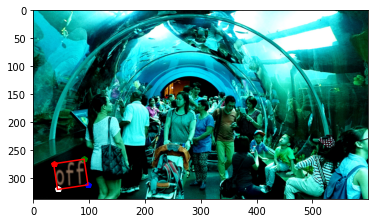

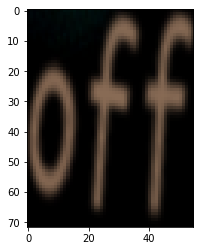

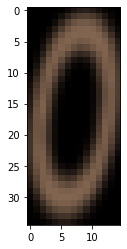

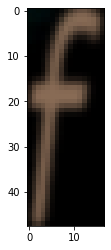

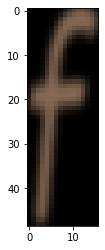

In [14]:
%%time
x_train = []
y_train = []
populate(train_filename, x_train, y_train)
print(f"x_train length: {len(x_train)} y_train length: {len(y_train)}")

plot_image(train_filename, 10)

## Noise for images - example

## Add noisy to training set

## Pyramid of Gaussian example

## Add pyramid of gaussian data to training data

# Read validation set

In [15]:
file_name = "validation_set/SynthText_val.h5"

db = h5py.File(file_name, "r")
IM_NAMES = list(db["data"].keys())

num_of_images = len(IM_NAMES)
print(f"Validation - Number of images: {num_of_images}")


            

Validation - Number of images: 520


In [16]:
%%time
x_val = [] #Images
y_val = [] #Labels

populate(val_filename, x_val, y_val)
print(f"x_val length: {len(x_val)} y_val length: {len(y_val)}")

Number of images: 520


<ipython-input-10-d0126fe6ca79>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-10-d0126fe6ca79>:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


x_val length: 8198 y_val length: 8198
CPU times: user 44.5 s, sys: 43 s, total: 1min 27s
Wall time: 10.6 s


## Create model

In [31]:
input_shape = (AVG_CHAR_HEIGHT, AVG_CHAR_WIDTH, 1)
print("Input shape: ", input_shape)

"""
# You can use VGG16 or any other built in model
model = tf.keras.applications.VGG16()
model.compile(metrics=['accuracy'])
"""

model = tf.keras.models.Sequential(
    [
        keras.Input(shape=input_shape),
        
        layers.Conv2D(128, kernel_size=(9, 9), activation="relu"),
        
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),

        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(3, activation="softmax"),
    ]
)

OPTIMIZERS = ["SGD", "adam", "adadelta", "adagrad"]
optimizer = keras.optimizers.Adam()
optimizer = keras.optimizers.Adamax(learning_rate=.000085)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build()
model.summary()

Input shape:  (49, 28, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 41, 20, 128)       10496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 10, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 8, 256)        295168    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 4, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 2, 512)         1180160   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 1, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)         

# Train

In [33]:
%%time
X_train = np.array(x_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
Y_train = np.array(y_train)


X_val = np.array(x_val)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
Y_val = np.array(y_val)

print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)

print("X val shape: ", X_val.shape)
print("Y val shape: ", Y_val.shape)



X train shape:  (12236, 49, 28, 1)
Y train shape:  (12236,)
X val shape:  (8198, 49, 28, 1)
Y val shape:  (8198,)
CPU times: user 78.1 ms, sys: 141 ms, total: 219 ms
Wall time: 218 ms


In [34]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50) 

Epoch 1/50
383/383 [==============================] - 32s 83ms/step - loss: 0.9127 - accuracy: 0.6017 - val_loss: 0.4918 - val_accuracy: 0.8137
Epoch 2/50
383/383 [==============================] - 33s 85ms/step - loss: 0.4438 - accuracy: 0.8318 - val_loss: 0.3643 - val_accuracy: 0.8666
Epoch 3/50
383/383 [==============================] - 33s 85ms/step - loss: 0.3409 - accuracy: 0.8705 - val_loss: 0.3190 - val_accuracy: 0.8827
Epoch 4/50
383/383 [==============================] - 33s 85ms/step - loss: 0.2774 - accuracy: 0.8953 - val_loss: 0.2819 - val_accuracy: 0.8868
Epoch 5/50
383/383 [==============================] - 34s 89ms/step - loss: 0.2477 - accuracy: 0.9014 - val_loss: 0.2246 - val_accuracy: 0.9149
Epoch 6/50
383/383 [==============================] - 33s 87ms/step - loss: 0.2274 - accuracy: 0.9095 - val_loss: 0.2169 - val_accuracy: 0.9180
Epoch 7/50
383/383 [==============================] - 32s 84ms/step - loss: 0.1961 - accuracy: 0.9209 - val_loss: 0.2089 - val_accuracy:

## Draw result for training

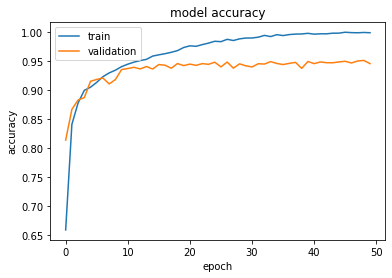

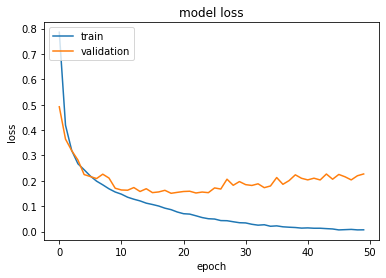

<IPython.core.display.Javascript object>

In [35]:
%%notify

#print(history.history.keys())

# summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
try:
    plt.plot(history.history['val_accuracy'])
except:
    pass
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
try:
    plt.plot(history.history['val_loss'])
except:
    pass
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate

In [36]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_train, Y_train, batch_size=128)
print("test loss, test acc:", results)

print("Evaluate on validation data")
results = model.evaluate(X_val, Y_val, batch_size=128)
print("val loss, val acc:", results)

Evaluate on test data
96/96 [==============================] - 11s 114ms/step - loss: 0.0085 - accuracy: 0.9988
test loss, test acc: [0.008466781117022038, 0.9987741112709045]
Evaluate on validation data
65/65 [==============================] - 7s 112ms/step - loss: 0.2270 - accuracy: 0.9452
val loss, val acc: [0.2269996702671051, 0.9452305436134338]


# Show training images

6


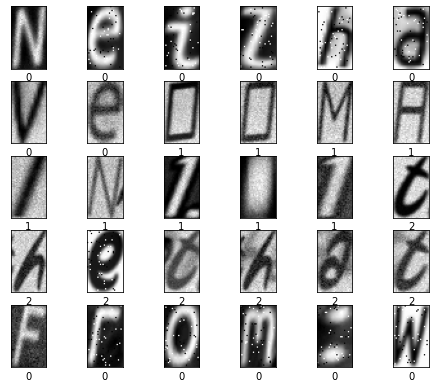

In [21]:
plot_samples(X_train, Y_train, low=520, high=550)

# Save model

In [41]:
model.save("saved_model.h5")

# Predict

In [38]:
%%time

_from = 0
_to = -1

prediction_set = X_val[_from:_to]
ground_truth = Y_val[_from:_to]

prediction = model.predict(prediction_set)

confusion_predictions = []

for i in range(prediction.shape[0]):
    predictions = prediction[i]
    m = np.max(prediction[i]) # Maximum prediction
    font_predicted = list(np.where(prediction[i] == m))[0][0]
    font_truth = ground_truth[i]
    success = (font_predicted == font_truth)
    confusion_predictions.append([font_predicted, font_truth, m, success])


CPU times: user 27.5 s, sys: 703 ms, total: 28.2 s
Wall time: 3.25 s


# Confusion matrix

<AxesSubplot:>

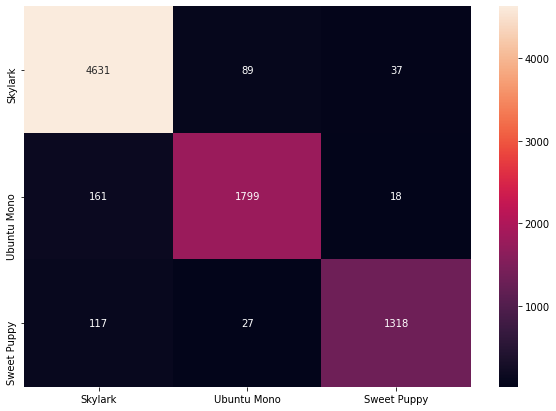

In [39]:
array = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0 ,0]
]

# Rows = Predicted
# Cols = Ground truth

for x in confusion_predictions:
    # Select where to put in confusion matrix
    row = None
    col = None
    
    # Unwrap x
    font_predicted = x[0]
    font_truth = x[1]
    prediction_acc = x[2]
    success = x[3]
    
    # If predicted successfully
    if success:
        # Then put in (i, i)
        row = col = font_predicted
    
    # Wrong prediction
    else:
        col = font_truth
        row = font_predicted
    
    array[row][col] += 1

#revese = FONTS[::-1]
df_cm = pd.DataFrame(array, 
                     index = FONTS,
                     columns = FONTS)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')


# Calculate accuracy from confusion matrix

In [40]:
yes = array[0][0] + array[1][1] + array[2][2]
no = array[0][1] + array[0][2] + array[1][0] + array[1][2] + array[2][0] + array[2][1]

print(yes)
print(no)

total = yes+no

acc = yes/total
print("Accuracy: ", acc)

7748
449
Accuracy:  0.9452238623886788


# Load model

In [42]:

model = keras.models.load_model("saved_model.h5")

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 41, 20, 128)       10496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 10, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 8, 256)        295168    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 4, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 2, 512)         1180160   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 1, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)             

In [43]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_train, Y_train, batch_size=128)
print("test loss, test acc:", results)

print("Evaluate on validation data")
results = model.evaluate(X_val, Y_val, batch_size=128)
print("val loss, val acc:", results)

Evaluate on test data
96/96 [==============================] - 11s 112ms/step - loss: 0.0085 - accuracy: 0.9988
test loss, test acc: [0.008466781117022038, 0.9987741112709045]
Evaluate on validation data
65/65 [==============================] - 8s 116ms/step - loss: 0.2270 - accuracy: 0.9452
val loss, val acc: [0.2269996702671051, 0.9452305436134338]
